In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft, fftfreq
from lal import MTSUN_SI, PC_SI
from astropy.cosmology import FlatLambdaCDM
import json
import corner
# import fitsio
import pandas as pd
import pickle
import matplotlib
# plt.rcParams.update({'font.size': 30})
matplotlib.rcParams['text.usetex'] = True

%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

/tmp/ipykernel_50006/2664699028.py:6: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import MTSUN_SI, PC_SI


In [3]:
cat_fname = '../data/22137.fits'
npcat = fitsio.read(cat_fname)#, columns=columns)
npcat = npcat.byteswap().newbyteorder()
data_frame = pd.DataFrame.from_records(npcat)

In [ ]:
data_frame

In [4]:
data_frame

,ra_gal,dec_gal,lml_r,lmstellar,gr_gal,z_cgal_v,cgal_v,sdss_r_abs_mag,sdss_r_true
0,29.541288,49.857072,0.276,8.928,0.6059,0.37134,1029.729980,-16.948999,24.006001
1,28.441890,46.855318,0.093,9.741,0.8867,1.03315,2445.000000,-19.440001,24.813000
2,23.756635,45.539439,-0.017,9.973,0.5700,0.80689,2017.369995,-20.297001,23.231001
3,21.181120,45.094274,-0.215,8.719,0.4156,0.63212,1648.680054,-17.656000,24.301001
4,27.245523,52.765286,0.004,9.135,0.4853,0.52097,1395.300049,-18.146999,23.535999
...,...,...,...,...,...,...,...,...,...
8041973,26.542781,49.585496,-0.243,9.467,0.3811,0.95812,2309.010010,-19.594999,23.487000
8041974,25.647545,49.625768,0.056,9.805,0.8199,1.05884,2490.280029,-19.691000,24.627001
8041975,29.689347,44.508871,-0.150,9.388,0.4043,1.08193,2530.459961,-19.164000,24.393000
8041976,24.016464,48.424273,0.242,9.866,0.6346,0.35108,978.049988,-19.379999,21.409000


In [10]:
max(data_frame['lmstellar'])

12.043000221252441

In [6]:
10**data_frame['lml_r'][0]

1.8879913190387296

In [9]:
10**data_frame['lmstellar'][0]*0.7

593059804.5882635

In [15]:
10**data_frame['lmstellar'][0]*0.7/10**data_frame['lml_r'][0]

314122103.53288054

In [20]:
4.65-2.5*(data_frame['lmstellar'][0]-data_frame['lml_r'][0])

-16.980001068115236

In [24]:
10**(0.2*(data_frame['sdss_r_true'][0]+16.98+5))*1e-6

1574.708253512318

In [31]:
cosmo = FlatLambdaCDM(H0=70,Om0=0.25)

In [32]:
cosmo.luminosity_distance(data_frame['z_cgal_v'][0])

<Quantity 2017.34909564 Mpc>

In [33]:
cosmo.comoving_distance(data_frame['z_cgal_v'][0])

<Quantity 1471.07872274 Mpc>

In [34]:
cosmo.comoving_distance(data_frame['z_cgal_v'][0])*0.7

<Quantity 1029.75510592 Mpc>

In [14]:
def dL_from_ML(lm,lml,m):
    Mabs = 4.65-2.5*(lm-lml)
    return 10**(0.2*(m-Mabs+5))*1e-6

In [9]:
with open('sampling_sis_GO_seed_0_ind_5081/label_result.json', 'r') as file: 
    data = json.load(file)

In [10]:
data['posterior']['content'].keys()

dict_keys(['m1', 'm2', 'DL', 'iota', 'tc_plus', 'tc_minus', 'phic_plus', 'phic_minus', 'log_likelihood', 'log_prior'])

In [13]:
label = ['dL','tc_plus','tc_minus']

val = np.array([data['posterior']['content']['DL'], data['posterior']['content']['tc_plus'], data['posterior']['content']['tc_minus']]).T

<Figure size 640x480 with 0 Axes>

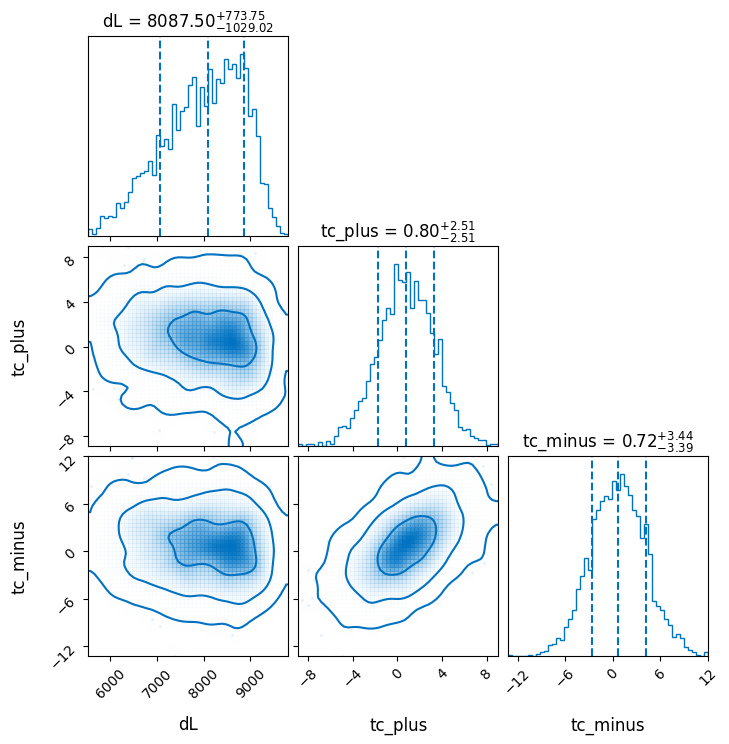

In [14]:
ndim = 3

plt.figure()
fig = corner.corner(val, labels=label, bins=50, smooth=2, label_kwargs=dict(fontsize=12), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})
axes = np.array(fig.axes).reshape((ndim, ndim))


In [30]:
from scipy.stats import gaussian_kde
kde_dL = gaussian_kde(data['posterior']['content']['DL'])
kde_dL_rw = gaussian_kde(data['posterior']['content']['DL'],weights=1/np.array(data['posterior']['content']['DL'])**2)


/tmp/ipykernel_349411/3016171473.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  plt.plot(dL_arr,p_dL_rmp/simps(p_dL_rmp,dL_arr),linestyle='--')


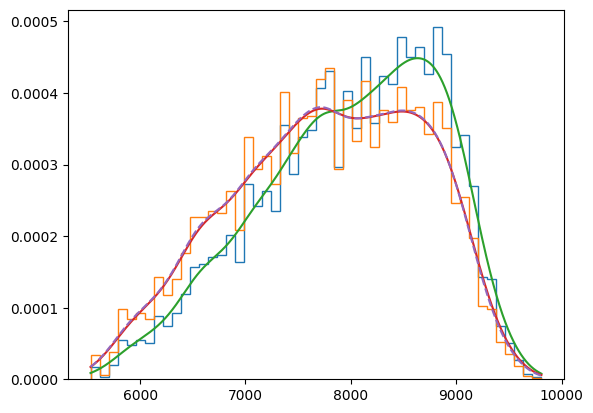

In [31]:
dL_arr = np.linspace(min(data['posterior']['content']['DL']),max(data['posterior']['content']['DL']),10000)
p_dL = kde_dL(dL_arr)
p_dL_rw = kde_dL_rw(dL_arr)
p_dL_rmp = kde_dL(dL_arr)/dL_arr**2
plt.hist(data['posterior']['content']['DL'],bins=50,histtype='step',density=True)
plt.hist(data['posterior']['content']['DL'],bins=50,histtype='step',density=True,weights=1/np.array(data['posterior']['content']['DL'])**2)
plt.plot(dL_arr,p_dL)
plt.plot(dL_arr,p_dL_rw)
plt.plot(dL_arr,p_dL_rmp/simps(p_dL_rmp,dL_arr),linestyle='--')

In [39]:
import random
dL_data_rw = random.choices(dL_arr,weights=p_dL_rmp,k=10000)

In [38]:
len(data['posterior']['content']['DL'])

3420

In [40]:
print(np.mean(data['posterior']['content']['DL']),np.mean(dL_data_rw), np.std(data['posterior']['content']['DL']),np.std(dL_data_rw))

7979.946451094498 7779.209367445219 848.7941617124542 890.7880218178083


(array([  1.,   0.,   0.,   1.,   1.,   1.,   2.,   2.,   3.,   2.,   2.,
          9.,  14.,  20.,  31.,  17.,  36.,  45.,  63.,  70., 106., 118.,
        134., 140., 172., 181., 211., 209., 225., 241., 194., 214., 171.,
        163., 116., 114.,  93.,  80.,  60.,  46.,  23.,  14.,  15.,  11.,
          9.,   3.,   1.,   1.,   0.,   1.]),
 array([-6.17628547, -5.96253583, -5.74878619, -5.53503655, -5.32128691,
        -5.10753727, -4.89378764, -4.680038  , -4.46628836, -4.25253872,
        -4.03878908, -3.82503944, -3.61128981, -3.39754017, -3.18379053,
        -2.97004089, -2.75629125, -2.54254161, -2.32879198, -2.11504234,
        -1.9012927 , -1.68754306, -1.47379342, -1.26004378, -1.04629415,
        -0.83254451, -0.61879487, -0.40504523, -0.19129559,  0.02245405,
         0.23620368,  0.44995332,  0.66370296,  0.8774526 ,  1.09120224,
         1.30495188,  1.51870151,  1.73245115,  1.94620079,  2.15995043,
         2.37370007,  2.58744971,  2.80119934,  3.01494898,  3.22869862,
 

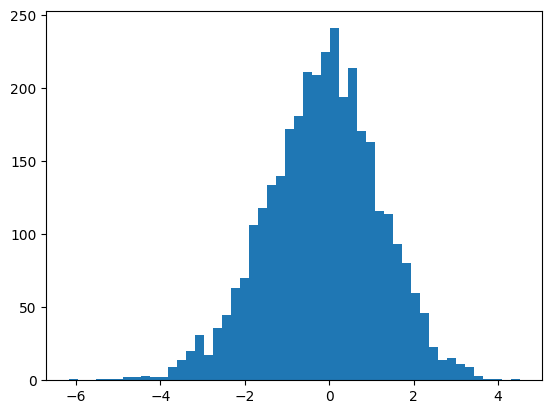

In [19]:
plt.hist(data['posterior']['content']['tc'],bins=50)

In [20]:
sigma_t = np.std(data['posterior']['content']['tc'])*1e-4


In [21]:
sigma_t

0.00013445899531775826

In [22]:
cosmo = FlatLambdaCDM(H0=70,Om0=0.308)
dls = cosmo.comoving_distance(1).value
print(dls)

3288.291830049882


In [ ]:
import scipy.constants as constants
print(constants.c)

299792458.0


In [ ]:
def t_delay_geom_plus(y):
    return (y**2. + 2. - y*np.sqrt(y**2 +4.))/4.-np.log(np.abs(y+np.sqrt(y**2+4.))/2.)
def t_delay_geom_minus(y):
    return (y**2 + 2. + y*np.sqrt(y**2 +4.))/4.-np.log(np.abs(y-np.sqrt(y**2+4.))/2.)
def DeltaT(y):
    return t_delay_geom_minus(y)-t_delay_geom_plus(y)

def t_delay_factor(H0,zL,zS,xi0):
    cosmo_H0 = FlatLambdaCDM(H0=H0,Om0=0.308)
    DL = cosmo_H0.angular_diameter_distance(zL).value
    DS = cosmo_H0.angular_diameter_distance(zS).value
    DLS = cosmo_H0.angular_diameter_distance_z1z2(zL,zS).value

    return (1+zL)/constants.c * DS/DL/DLS *(xi0*1e-6)**2 *PC_SI*1e6 #*DeltaT(y)


In [ ]:
H0 = 67.7
Om0 = 0.308
cosmo = FlatLambdaCDM(H0=H0,Om0=Om0)
zarr = np.linspace(0.01,10,10000)
dlarr = cosmo.luminosity_distance(zarr).value
z_of_dlH0 = interp1d(dlarr*H0,zarr)

In [7]:
H0_i = 67.7 #199.7
xi0_i = 23.4 #14.8

zS_samples = z_of_dlH0(np.array(data['posterior']['content']['luminosity_distance'])*H0_i)
delta_t = t_delay_factor(H0_i,0.1,zS_samples,xi0_i)*DeltaT(np.array(data['posterior']['content']['y']))


In [8]:
np.mean(delta_t)

451.06100516738474

In [9]:
zL=0.1
ML_GO=1e7
yh=1
t_delay_obs = DeltaT(yh)*4*ML_GO*(1+zL)*MTSUN_SI
print(t_delay_obs)

450.88011175683886


In [24]:
t_delay_factor(H0_i,0.1,0.4,xi0_i)*DeltaT(yh)


449.5471112764276

In [13]:
t_delay_factor(152.7,0.05,0.4,15.1)*DeltaT(1)


642.7020187096638

In [30]:
t_delay_factor(110,0.05,0.4,15)*DeltaT(1)


456.86925756580047

In [25]:
zS_min_temp = np.min(zS_samples)
zS_max_temp = np.max(zS_samples)
zS_array_temp = np.linspace(zS_min_temp,zS_max_temp,250)

zS_min_temp_t = np.min(zS_samples)*0.5
zS_max_temp_t = np.max(zS_samples)*1.5
zS_array_temp_t = np.linspace(zS_min_temp_t,zS_max_temp_t,250)


In [39]:
y_min_temp = np.min(data['posterior']['content']['y'])
y_max_temp = np.max(data['posterior']['content']['y'])
y_array_temp = np.linspace(y_min_temp,y_max_temp,250)


In [40]:
from scipy.stats import gaussian_kde
kde_zS = gaussian_kde(zS_samples) 
kde_y = gaussian_kde(data['posterior']['content']['y'])

In [41]:
zS_prob = kde_zS(zS_array_temp)
t_delay_factor_temp = t_delay_factor(H0_i,zL,zS_array_temp,xi0_i)
t_delay_factor_sum = simps(t_delay_factor_temp*zS_prob, zS_array_temp)

/tmp/ipykernel_5686/2128750768.py:3: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  t_delay_factor_sum = simps(t_delay_factor_temp*zS_prob, zS_array_temp)


In [42]:
t_delay_factor_sum

215.22059045899456

In [43]:
y_prob = kde_y(y_array_temp)
delta_T_temp = DeltaT(y_array_temp)
delta_T_sum = simps(delta_T_temp*y_prob, y_array_temp)

/tmp/ipykernel_5686/184275012.py:3: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  delta_T_sum = simps(delta_T_temp*y_prob, y_array_temp)


In [45]:
t_delay_factor_sum*delta_T_sum

450.1292060074671

In [32]:
t_delay_factor_samps = t_delay_factor(H0_i,zL,zS_samples,xi0_i)
kde_t_delay_factor = gaussian_kde(t_delay_factor_samps) 

t_delay_factor_array_temp = np.linspace(min(t_delay_factor_samps),max(t_delay_factor_samps),250)

In [34]:
t_delay_factor(H0_i,zL,0.4,xi0_i)

216.08087705202837

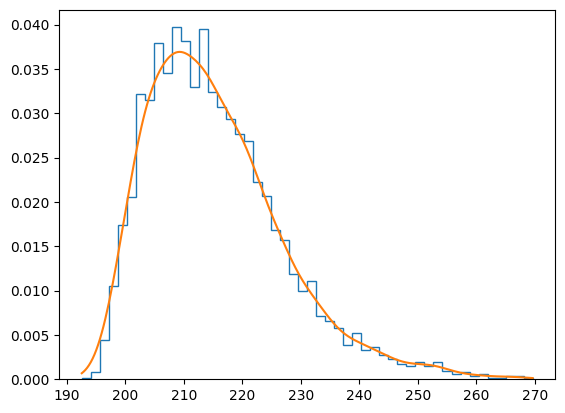

In [33]:
plt.hist(t_delay_factor_samps,bins=50,density=True,histtype='step')
plt.plot(t_delay_factor_array_temp,kde_t_delay_factor(t_delay_factor_array_temp))

In [36]:
delta_T_samps = DeltaT(np.array(data['posterior']['content']['y']))
kde_delta_T = gaussian_kde(delta_T_samps) 

delta_T_array_temp = np.linspace(min(delta_T_samps),max(delta_T_samps),250)

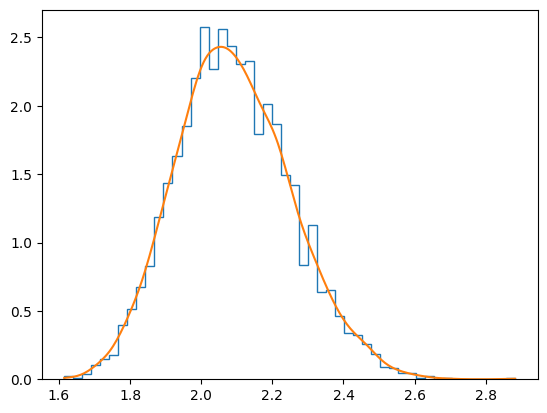

In [37]:
plt.hist(delta_T_samps,bins=50,density=True,histtype='step')
plt.plot(delta_T_array_temp,kde_delta_T(delta_T_array_temp))

In [38]:
t_delay_factor_sum = simps(kde_t_delay_factor(t_delay_factor_array_temp), t_delay_factor_array_temp)
delta_T_sum = simps(kde_delta_T(delta_T_array_temp), delta_T_array_temp)

delta_t_thy = t_delay_factor_sum*delta_T_sum
print(delta_t_thy)

0.9984617907234979


/tmp/ipykernel_5686/1293218916.py:1: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  t_delay_factor_sum = simps(kde_t_delay_factor(t_delay_factor_array_temp), t_delay_factor_array_temp)
/tmp/ipykernel_5686/1293218916.py:2: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  delta_T_sum = simps(kde_delta_T(delta_T_array_temp), delta_T_array_temp)


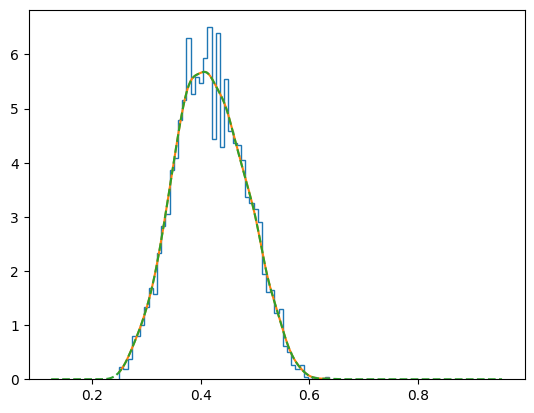

In [26]:
plt.hist(zS_samples,bins=50,density=True,histtype='step')
plt.plot(zS_array_temp,kde_zS(zS_array_temp))
plt.plot(zS_array_temp_t,kde_zS(zS_array_temp_t),linestyle='--')

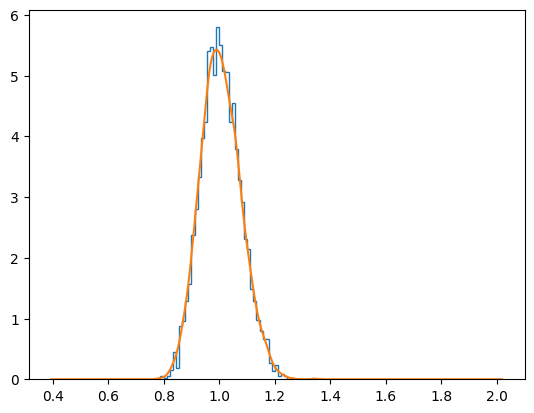

In [21]:
plt.hist(data['posterior']['content']['y'],bins=50,density=True,histtype='step')
plt.plot(y_array_temp,kde_y(y_array_temp))

In [33]:
z_ind=np.array([0.01,0.02,0.1,0.2])

In [34]:
z_ind[np.where(z_ind<0.1)[0]]

array([0.01, 0.02])

In [4]:
with open('../O5_Tobs5_snr11/GW_injections_O5.p', 'rb') as file: 
    data = pickle.load(file)

In [20]:
data['injections_parameters']['geocent_time']

array([69066.15573629, 46447.37679829, 17769.5708293 ,  2082.13220578,
       70394.58362061, 36044.77990285,  2900.63253559, 84629.01775023,
       55977.36237511, 81245.75411244,  5797.68810475, 57948.00015437,
       84506.82255849, 74350.19690965,  8232.94768176,  4143.94226565,
       84145.87384124, 75003.74619931, 32844.38739454, 19167.61636436,
       68706.80051088, 36821.83404165,  1457.92336017, 79128.97664721,
       22134.05151081, 34433.04637243, 81428.27615363,  8413.50438184,
       59557.29714382, 27505.58954128, 68814.92367637, 10023.14489412,
       20181.09397689, 56398.57482575, 76427.1592488 , 70194.83569399,
       68500.26772304,  1283.75607518, 19737.37450737, 10079.91440734,
       17093.61093645,  6369.61368706, 11224.22011944, 71994.69634645,
       13599.06693589, 11866.86829502, 76168.48137554, 64364.69919983,
       21271.29437488, 55718.20634449, 66843.23139781, 27197.00361374,
       23628.35145862, 14318.63331954, 64986.29938865, 64518.34064749,
      

(array([10., 13.,  3.,  3.,  1.,  3.,  4.,  2.,  3.,  5., 10., 15.,  2.,
         3.,  1.,  2.,  1.,  3.,  1.,  1.,  4.,  3.,  1.,  2.,  1.,  1.,
         2.,  4.,  1.,  1.]),
 array([ 7.10425157,  9.56840899, 12.0325664 , 14.49672382, 16.96088124,
        19.42503866, 21.88919607, 24.35335349, 26.81751091, 29.28166833,
        31.74582574, 34.20998316, 36.67414058, 39.138298  , 41.60245541,
        44.06661283, 46.53077025, 48.99492766, 51.45908508, 53.9232425 ,
        56.38739992, 58.85155733, 61.31571475, 63.77987217, 66.24402959,
        68.708187  , 71.17234442, 73.63650184, 76.10065926, 78.56481667,
        81.02897409]),
 <BarContainer object of 30 artists>)

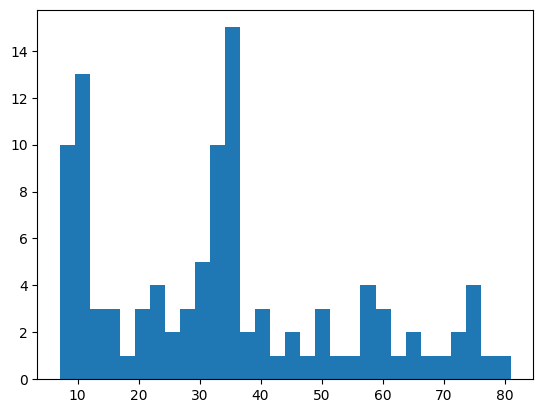

In [8]:
plt.hist(data['injections_parameters']['m1s'],bins=30)

(array([ 5.,  9.,  4.,  5.,  9., 13.,  9.,  6.,  4.,  6.,  5.,  4.,  2.,
         8.,  3.,  2.,  2.,  1.,  2.,  1.,  2.,  1.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.07623485, 0.11815117, 0.16006749, 0.20198381, 0.24390013,
        0.28581645, 0.32773277, 0.36964909, 0.41156541, 0.45348173,
        0.49539805, 0.53731438, 0.5792307 , 0.62114702, 0.66306334,
        0.70497966, 0.74689598, 0.7888123 , 0.83072862, 0.87264494,
        0.91456126, 0.95647758, 0.9983939 , 1.04031023, 1.08222655,
        1.12414287, 1.16605919, 1.20797551, 1.24989183, 1.29180815,
        1.33372447]),
 <BarContainer object of 30 artists>)

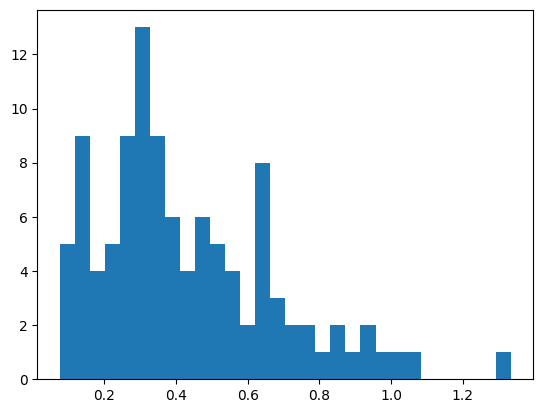

In [18]:
plt.hist(data['injections_parameters']['zs'],bins=30)

(array([28., 20., 11., 11., 12.,  3.,  4.,  3.,  2.,  1.,  1.,  1.,  0.,
         1.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.]),
 array([20.1388935 , 22.26396786, 24.38904222, 26.51411657, 28.63919093,
        30.76426529, 32.88933964, 35.014414  , 37.13948835, 39.26456271,
        41.38963707, 43.51471142, 45.63978578, 47.76486013, 49.88993449,
        52.01500885, 54.1400832 , 56.26515756, 58.39023191, 60.51530627,
        62.64038063, 64.76545498, 66.89052934, 69.01560369, 71.14067805,
        73.26575241, 75.39082676, 77.51590112, 79.64097547, 81.76604983,
        83.89112419]),
 <BarContainer object of 30 artists>)

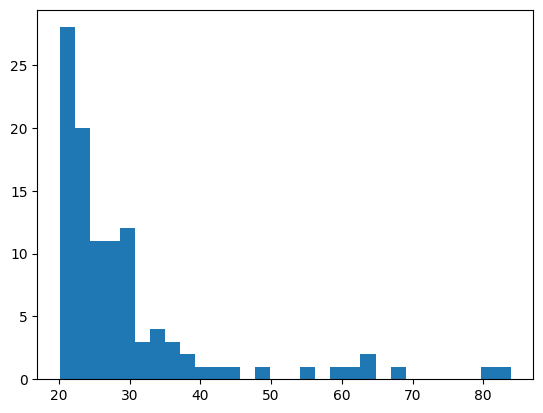

In [19]:
plt.hist(data['injections_parameters']['snrs'],bins=30)

In [9]:
with open('../O5_Tobs5_snr11/GW_injections_O5_galaxies.p', 'rb') as file: 
    galdata = pickle.load(file)

In [12]:
len(galdata['zs'])

23702

(array([   4.,    9.,   11.,   12.,   23.,   28.,   48.,   63.,   55.,
         107.,  106.,  112.,  151.,  162.,  210.,  211.,  264.,  282.,
         287.,  361.,  374.,  403.,  468.,  525.,  538.,  625.,  654.,
         705.,  695.,  811.,  897.,  928.,  977., 1049., 1027., 1180.,
        1186., 1333., 1231., 1268., 1242., 1009.,  845.,  564.,  347.,
         177.,   97.,   25.,   12.,    4.]),
 array([0.07623485, 0.10745648, 0.13867811, 0.16989975, 0.20112138,
        0.23234302, 0.26356465, 0.29478629, 0.32600792, 0.35722956,
        0.38845119, 0.41967283, 0.45089446, 0.48211609, 0.51333773,
        0.54455936, 0.575781  , 0.60700263, 0.63822427, 0.6694459 ,
        0.70066754, 0.73188917, 0.76311081, 0.79433244, 0.82555407,
        0.85677571, 0.88799734, 0.91921898, 0.95044061, 0.98166225,
        1.01288388, 1.04410552, 1.07532715, 1.10654878, 1.13777042,
        1.16899205, 1.20021369, 1.23143532, 1.26265696, 1.29387859,
        1.32510023, 1.35632186, 1.3875435 , 1.41876513, 

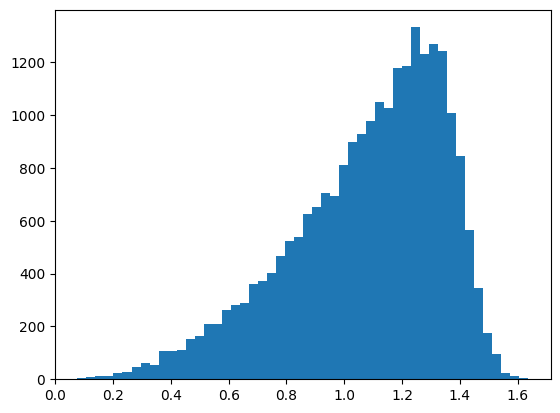

In [13]:
plt.hist(galdata['zs'],bins=50)

In [14]:
with open('../O5_Tobs5_snr11/GW_injections_O5_masses.p', 'rb') as file: 
    massdata = pickle.load(file)

(array([1.308e+03, 3.539e+03, 7.555e+03, 5.056e+03, 1.112e+03, 7.300e+02,
        5.720e+02, 4.110e+02, 3.000e+02, 2.420e+02, 2.060e+02, 1.940e+02,
        1.640e+02, 1.770e+02, 2.420e+02, 2.660e+02, 2.800e+02, 2.840e+02,
        2.470e+02, 2.030e+02, 1.520e+02, 8.100e+01, 6.200e+01, 4.600e+01,
        3.100e+01, 2.900e+01, 1.300e+01, 2.000e+01, 1.100e+01, 1.200e+01,
        2.000e+01, 9.000e+00, 1.200e+01, 9.000e+00, 8.000e+00, 1.000e+01,
        7.000e+00, 1.100e+01, 1.500e+01, 9.000e+00, 3.000e+00, 6.000e+00,
        3.000e+00, 6.000e+00, 5.000e+00, 5.000e+00, 5.000e+00, 5.000e+00,
        4.000e+00, 5.000e+00]),
 array([ 5.4204585 ,  6.9882938 ,  8.55612909, 10.12396439, 11.69179969,
        13.25963499, 14.82747029, 16.39530559, 17.96314089, 19.53097619,
        21.09881149, 22.66664679, 24.23448209, 25.80231738, 27.37015268,
        28.93798798, 30.50582328, 32.07365858, 33.64149388, 35.20932918,
        36.77716448, 38.34499978, 39.91283508, 41.48067037, 43.04850567,
        44.

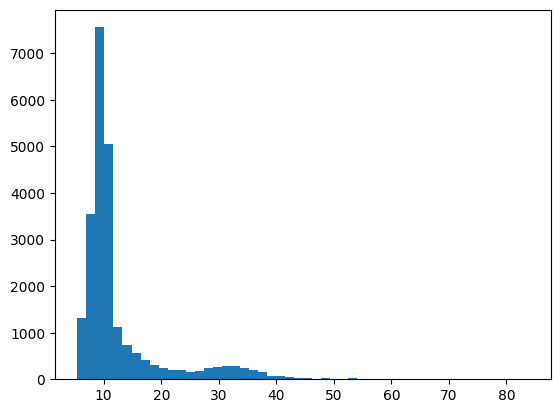

In [17]:
plt.hist(massdata['m1s'],bins=50)

In [2]:
ind_dict = np.load('event_ind.npy',allow_pickle=True).item()


In [8]:
y_max = []
for arr in ind_dict['y_ind']:
    y_max.append(max(arr))

In [20]:
np.where(np.array(y_max)>0.85)

(array([ 72, 113, 161, 178, 210, 212, 240, 252, 291, 294, 330, 332, 339]),)

In [26]:
np.array(y_max)[np.where(np.array(y_max)>0.85)]

array([0.86308631, 0.86668667, 0.87058706, 0.86838684, 0.8879888 ,
       0.86748675, 0.89058906, 0.85368537, 0.86858686, 0.88118812,
       0.90719072, 0.87958796, 0.90639064])

In [28]:
np.sqrt(1/0.87-1)

0.3865556717425341

In [22]:
np.array(ind_dict['seed'])[np.where(np.array(y_max)>0.85)[0]]

array([192, 312, 449, 483, 559, 561, 640, 688, 809, 814, 927, 930, 950])

In [15]:
with open('/home/ansonchen/dark_energy_O4a/O5_Tobs5_snr11/GW_injections_O5.p', 'rb') as file: 
    data = pickle.load(file)

In [25]:
np.array(data['injections_parameters']['snrs'])[np.array(ind_dict['seed'])[np.where(np.array(y_max)>0.85)[0]]]

array([16.30807989, 14.84830238, 11.17656716, 17.92358812, 26.42508873,
       11.27274034, 46.99441029, 12.59836566, 16.84630893, 17.59640866,
       12.59945014, 15.36258042, 17.33363027])

In [5]:
zS_max = []
for arr in ind_dict['zS_ind']:
    zS_max.append(max(arr))

In [11]:
np.where(np.array(zS_max)==max(zS_max))

(array([244]),)

In [10]:
np.array(ind_dict['seed'])[np.where(np.array(zS_max)>2)[0]]

array([ 16,  35,  38,  39,  52,  63,  68,  73,  75, 123, 139, 141, 170,
       172, 198, 201, 203, 207, 247, 270, 346, 358, 374, 376, 378, 397,
       419, 434, 457, 474, 489, 504, 516, 560, 573, 588, 593, 605, 606,
       619, 629, 640, 648, 675, 716, 732, 734, 739, 751, 762, 791, 793,
       801, 832, 889, 900, 915, 925, 939, 943, 951, 954, 961, 972, 981])

In [12]:
np.array(ind_dict['seed'])[244]

648

In [13]:
np.array(ind_dict['zS_ind'])[244]

/tmp/ipykernel_51181/685050278.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(ind_dict['zS_ind'])[244]


array([3.36789415])

In [15]:
with open('/home/ansonchen/dark_energy_O4a/O6_Tobs5_snr11/GW_injections_O6.p', 'rb') as file: 
    data = pickle.load(file)

In [16]:
data['injections_parameters']['dets_pe']

[array(['H1', 'V1', 'K1'], dtype='<U4'),
 array(['H1', 'L1'], dtype='<U4'),
 array(['H1', 'L1', 'K1', 'A1'], dtype='<U4'),
 array(['H1', 'L1', 'V1'], dtype='<U2'),
 array(['H1', 'L1'], dtype='<U4'),
 array(['H1', 'L1'], dtype='<U2'),
 array(['L1'], dtype='<U4'),
 array(['H1', 'L1'], dtype='<U4'),
 array(['H1', 'L1', 'A1'], dtype='<U4'),
 array(['H1', 'L1'], dtype='<U4'),
 array(['H1'], dtype='<U4'),
 array(['H1', 'L1'], dtype='<U2'),
 array(['H1', 'L1'], dtype='<U4'),
 array(['H1', 'L1'], dtype='<U4'),
 array(['H1'], dtype='<U4'),
 array(['H1', 'L1'], dtype='<U2'),
 array(['H1', 'L1'], dtype='<U4'),
 array(['H1'], dtype='<U2'),
 array(['H1', 'L1'], dtype='<U4'),
 array(['H1', 'L1', 'A1'], dtype='<U4'),
 array(['H1', 'L1'], dtype='<U4'),
 array(['H1', 'L1'], dtype='<U4'),
 array(['L1'], dtype='<U4'),
 array(['V1', 'A1'], dtype='<U4'),
 array(['H1', 'L1'], dtype='<U4'),
 array(['H1', 'L1'], dtype='<U4'),
 array(['L1'], dtype='<U4'),
 array(['H1', 'L1', 'A1'], dtype='<U4'),
 array(['H1', 

In [27]:
lik = np.load(f'../likelihood/H0_Om0_cM_loglik_seed_0_combine.npz')['arr_0']

In [46]:
# comb_likelihood = np.loadtxt(f'../likelihood/H0_Om0_loglik_seed_0_combine_test.txt')
comb_likelihood = np.loadtxt(f'../likelihood/H0_cM_loglik_seed_0_combine.txt')

In [16]:
# emcee_samples = np.loadtxt('../emcee_samples/emcee_H0_Om0_seed_0_samples.txt')
emcee_samples = np.loadtxt('../emcee_samples/emcee_H0_Om0_w0wa_seed_0_samples.txt')

<Figure size 640x480 with 0 Axes>

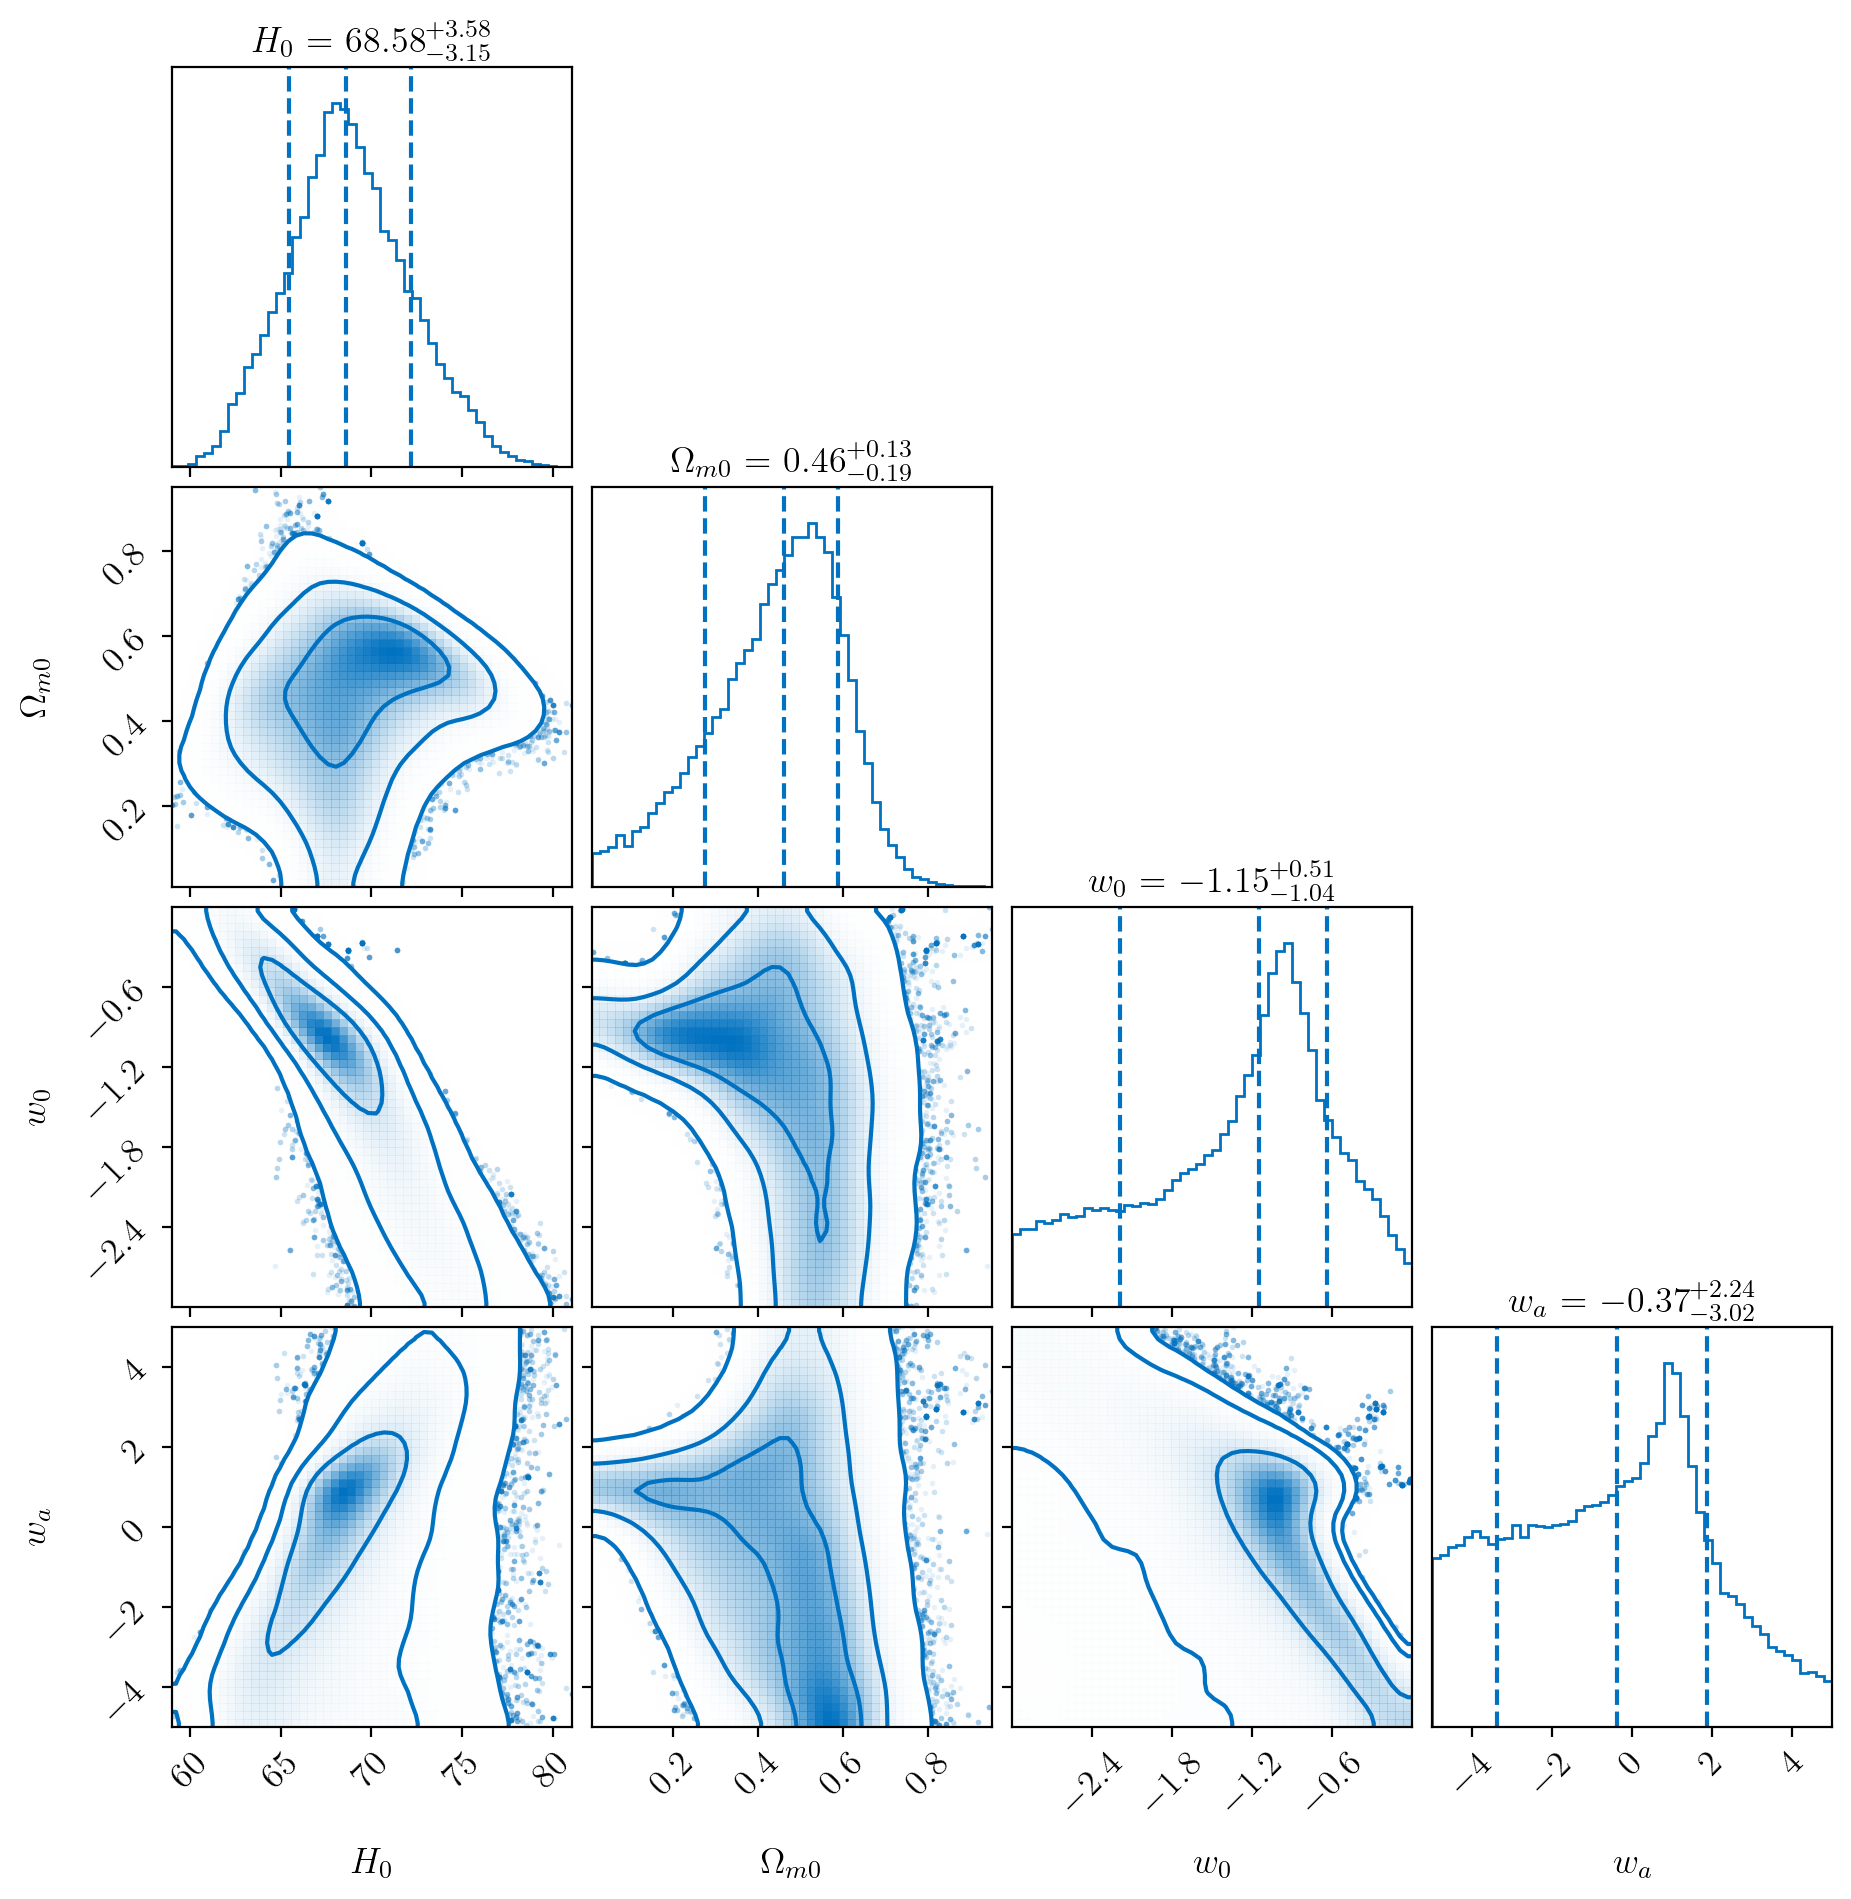

In [17]:
plt.figure()
label = [r'$H_0$',r'$\Omega_{m0}$',r'$w_0$',r'$w_a$']
plt.rcParams.update({'font.size': 13})

fig = corner.corner(emcee_samples, labels=label, bins=50, smooth=2, label_kwargs=dict(fontsize=13), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 13})
plt.savefig('../plots/emcee_H0_Om0_w0wa_combined_seed_0.png',dpi=600)

In [32]:
from scipy.stats import gaussian_kde

pH0_kde = gaussian_kde(emcee_samples[:,0])

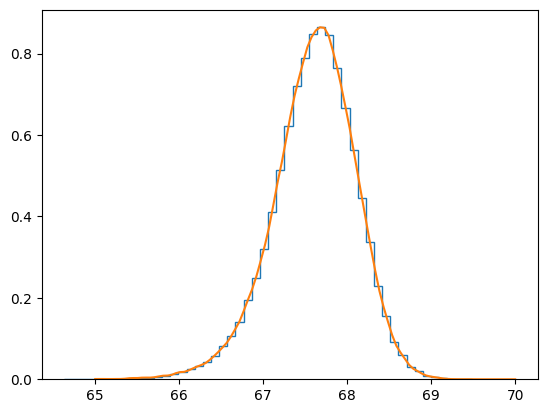

In [34]:
plt.hist(emcee_samples[:,0],bins=50,histtype='step',density=True)

H0_arr = np.linspace(65,70,100)
plt.plot(H0_arr, pH0_kde(H0_arr))

(array([1.38556588e-02, 5.27284795e-02, 1.43367581e-01, 3.21759189e-01,
        6.09071670e-01, 9.37951127e-01, 1.35785457e+00, 1.80893324e+00,
        2.19939340e+00, 2.68568854e+00, 3.12002495e+00, 3.44678758e+00,
        3.65443002e+00, 3.89786625e+00, 3.84013433e+00, 3.91268410e+00,
        3.75026499e+00, 3.58515172e+00, 3.32054713e+00, 2.96222440e+00,
        2.64777792e+00, 2.33313900e+00, 2.05987461e+00, 1.78853463e+00,
        1.47081667e+00, 1.17022585e+00, 9.87215692e-01, 7.80343008e-01,
        6.56026958e-01, 4.89566612e-01, 4.11820971e-01, 3.07903530e-01,
        2.32659605e-01, 1.70309140e-01, 1.38749028e-01, 8.54432295e-02,
        6.96631736e-02, 5.31133589e-02, 3.54089059e-02, 1.90515309e-02,
        1.13539427e-02, 1.23161412e-02, 9.62198530e-03, 6.92782942e-03,
        4.42611324e-03, 1.15463824e-03, 3.27147500e-03, 1.92439706e-03,
        7.69758824e-04, 5.77319118e-04]),
 array([0.02498362, 0.04122247, 0.05746132, 0.07370018, 0.08993903,
        0.10617788, 0.1224

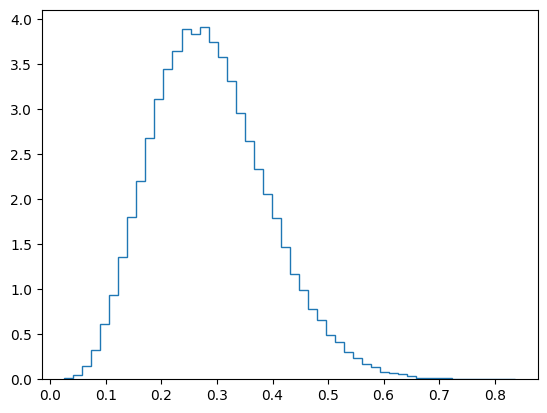

In [36]:
plt.hist(emcee_samples[:,1],bins=50,histtype='step',density=True)


In [49]:
pH0_Om0_kde = gaussian_kde(emcee_samples.T)

In [42]:
H0_arr = np.linspace(min(emcee_samples[:,0]),max(emcee_samples[:,0]),100)
Om0_arr = np.linspace(min(emcee_samples[:,1]),max(emcee_samples[:,1]),100)

H0_mesh, Om0_mesh = np.meshgrid(H0_arr,Om0_arr)

In [53]:
pH0_Om0 = np.zeros((len(H0_arr),len(Om0_arr)))

for i in range(len(H0_arr)):
    for j in range(len(Om0_arr)):
        pH0_Om0[i,j] = pH0_Om0_kde((H0_arr[i], Om0_arr[j]))

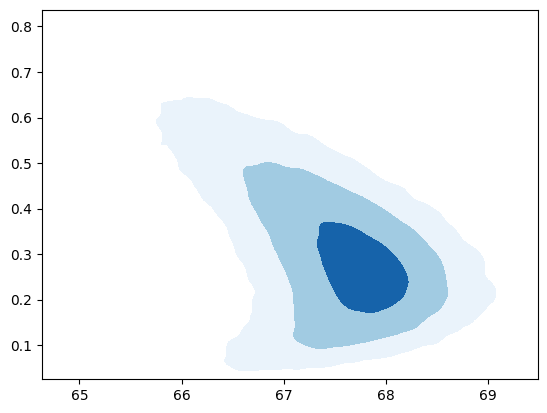

In [59]:
plt.contourf(H0_arr,Om0_arr,pH0_Om0.T,levels=(np.exp(-4.5)*np.max(pH0_Om0), np.exp(-2)*np.max(pH0_Om0),np.exp(-0.5)*np.max(pH0_Om0),np.max(pH0_Om0)),cmap='Blues')


In [57]:
np.max(pH0_Om0)

4.040566599677087

In [14]:
ind_dict = np.load('event_ind_XG.npy',allow_pickle=True).item()


In [14]:
len(ind_dict['seed'])

100

In [15]:
ind_dict['seed']

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [16]:
ind_dict['lensed_index']

[array([   1497,    4264,    4397,    5246,    7868,   16965,   27300,
          36202,   41786,   43451,   45804,   52140,   55831,   64077,
          65131,   66611,  117661,  118520,  128079,  140263,  146869,
         151766,  159350,  169018,  193652,  213272,  236369,  243302,
         247970,  248753,  258192,  273937,  283187,  286277,  291365,
         293757,  297280,  303861,  317827,  325570,  335983,  352217,
         354368,  374802,  378804,  392633,  397992,  398945,  420913,
         425039,  427279,  439108,  440467,  447142,  455876,  459956,
         476265,  490971,  491571,  497866,  502711,  506252,  508998,
         552363,  554513,  580439,  596054,  599488,  606888,  608381,
         612297,  612981,  651856,  673324,  689775,  692075,  693330,
         694318,  697537,  700596,  715325,  722160,  723147,  730681,
         742961,  758925,  778211,  783651,  785326,  794413,  807121,
         812150,  819166,  832651,  838587,  842435,  845059,  845887,
      

In [19]:
num = 0
lens = 0
lens0 = 0
for s in range(len(ind_dict['seed'])):
    seed = ind_dict['seed'][s]
    lens0 += len(ind_dict['lensed_index'][s])
    np.random.seed(seed)
    select_arr = []
    for k in range(len(ind_dict['lensed_index'][s])):
        select_arr.append(np.random.choice([0,1], size=1, p=[1-0.43,0.43])[0])
    visible_ind = np.where(ind_dict['lensed_index'][s] * np.array(select_arr)>0)[0]
    print(ind_dict['lensed_index'][s][visible_ind], ind_dict['y_ind'][s][visible_ind])
    if np.size(visible_ind)>0:
        num += 1
        lens += len(visible_ind)

[   4461    5294   17420   36371   41999   46029   65817  121487  136850
  152800  152996  153036  169462  180073  216430  242986  271924  275376
  275619  284885  288979  320130  336509  343646  366921  402082  446117
  477449  558443  579861  592267  626289  632850  644628  717185  769069
  782004  806611  811107  821312  849849  854987  882330  886182  895496
  899108  899479  921406  927503  933250  963151  994912 1001214 1004528
 1004728 1008112 1029788 1031715 1036369 1067591 1072513 1083850 1086728
 1089696 1090456 1119072 1144902 1149533 1154583 1197057 1215170 1234756
 1243489 1270010 1284586 1298026 1308610 1319112 1329840 1332595 1356334
 1381930 1424040 1438169 1441674 1459452 1466499 1488196 1488456 1496272
 1510903 1571334 1574297] [0.31483148 0.59415942 0.3610361  0.20182018 0.67946795 0.15261526
 0.40034003 0.3780378  0.60866087 0.70967097 0.57525753 0.58945895
 0.87518752 0.68426843 0.44844484 0.79487949 0.48734873 0.37943794
 0.72847285 0.05590559 0.1780178  0.0939093

In [18]:
num

100

In [19]:
lens/100

73.15

In [20]:
lens0/100

190.79

In [7]:
ind_dict['lensed_index'][-1], ind_dict['lensed_index'][-1][visible_ind]

(array([    281,     361,    3574,    5038,    7956,    9827,   11416,
          12103,   13754,   19360,   23168,   23435,   26301,   31129,
          32206,   52977,   55341,   66000,   68347,   68354,   71375,
          73433,   82084,   82429,   86334,   88399,   89971,   91560,
          91562,   91938,   94874,  103785,  110750,  112723,  116993,
         118229,  121058,  121837,  122993,  125079,  125644,  132844,
         136440,  136972,  144263,  144465,  147325,  150152,  151315,
         153467,  163369,  175608,  182767,  183654,  185407,  185803,
         193921,  195847,  197062,  197615,  200377,  200884,  206549,
         208735,  209245,  215244,  218746,  224949,  228598,  231665,
         238550,  248541,  252898,  259305,  260430,  270166,  273427,
         274528,  283666,  286670,  294047,  294793,  312929,  313682,
         316845,  323579,  324876,  325279,  333118,  336578,  345507,
         350613,  362554,  365064,  370473,  370688,  373053,  376098,
      

In [5]:
error = np.loadtxt('fisher_error_XG/fisher_error_XG_0.txt')

In [8]:
error[:,2]

array([ 2092.76704682,  2264.03277943,   614.11177506,  3167.56549282,
        1520.90148451,  2156.50359741,  2072.66950899,   551.9487536 ,
         606.74958096,   690.78955398,   412.90850927,  1352.95325488,
        5329.84770411,  5326.28476132,  1138.98812891,   128.4863883 ,
        1881.97807212,   348.33382511,   868.65373803,  4081.51869941,
        4787.75140192,  5418.48011737,  2957.61271477,  3727.80319538,
         812.5203047 ,  1947.43689081,  3503.58448287,   494.86407636,
        1595.13704721,  1338.86020883,  1886.17831297,  4555.30642568,
         589.0384134 ,  3897.56928837,   686.0746563 ,  3404.3330582 ,
        2622.31218826,  1174.46773009,   234.17496789,  2289.26301801,
        1532.66588051,  2808.98779473,   352.86326297,  8113.6758788 ,
        3714.81101639,  1645.03586203,   308.82746337,  4730.88888232,
         906.17535269,   862.45084918,  1279.21375919,  6401.49504779,
         788.824559  ,  1018.74686424,   572.08021957,   818.79790632,
      

In [9]:
error[:,4]

array([0.04549059, 0.01970033, 0.00652544, 0.019915  , 0.01721445,
       0.02291864, 0.03640459, 0.02370221, 0.01284508, 0.02990168,
       0.00923943, 0.01352407, 0.0245737 , 0.02792891, 0.04188226,
       0.01514327, 0.02976181, 0.01045508, 0.0733472 , 0.01522606,
       0.05378277, 0.02686912, 0.0319401 , 0.06650701, 0.01808581,
       0.01696304, 0.09221601, 0.0349002 , 0.02320863, 0.08425139,
       0.02592119, 0.03336635, 0.00775944, 0.02111838, 0.05065611,
       0.0223524 , 0.05470658, 0.0505857 , 0.01926197, 0.15097052,
       0.01501506, 0.03832297, 0.00369187, 0.058878  , 0.02219353,
       0.03055328, 0.00842531, 0.03055385, 0.03954432, 0.02480061,
       0.04577654, 0.05404561, 0.03754681, 0.0265147 , 0.02393213,
       0.02582795, 0.03371058, 0.07754348, 0.06678207, 0.02363646,
       0.00861501, 0.07265712, 0.02485968, 0.04158987, 0.03062887,
       0.07075527, 0.00624953, 0.0527429 , 0.05523994, 0.05601391,
       0.02485938, 0.0937564 , 0.03090108, 0.03877096, 0.00707

In [2]:
with open('/home/ansonchen/GW_lensing_dipole/XG_Tobs5_snr11/GW_injections_XG.p', 'rb') as file: 
    data = pickle.load(file)

In [3]:
data['injections_parameters']['dets']

array([list(['L1', 'ET']), list(['H1', 'ET']), list(['H1', 'L1', 'ET']),
       ..., list(['H1', 'L1', 'ET']), list(['H1', 'L1', 'ET']),
       list(['H1', 'L1'])], dtype=object)

In [10]:
10**(-1.77)

0.016982436524617443

In [11]:
np.log10(2.67e-3)

-2.5734887386354246

In [12]:
np.log10(1.23e-3)

-2.910094888560602